# Deduplicating Text in Common-Crawl for LLM Training. 

<a target="_blank" href="https://colab.research.google.com/github/everettVT/daft-minhash-dedupe/blob/main/workload/minhash_dedupe_common_crawl.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


In this notebook, we will cover how to perform the minhash deduplication algorithm on html documents from the common crawl dataset. By the end, we will walk through a practical approach to deduplicating text at scale.

The Common Crawl corpus contains petabytes of data, with its oldest entries dating back to 2008, including raw web page data, metadata extracts, and text extracts.

LLMs require massive amounts of data to train on. Early foundation models like GPT-3 and T5 saw improvements in model performance due to deduplication efforts. Deduplication makes it far less likely that the model regurgitates memorized text leading to better responses.

*See [Deduplicating Training Data Makes Language Models Better (Lee et. all)](https://aclanthology.org/2022.acl-long.577.pdf)*

---



## Table of Contents
- [Quickstart](#quickstart)
- [Introduction](#introduction)
- [AWS Authentication](#aws-authentication)
- [Loading and Preprocessing](#loading-and-preprocessing)
- [Normalization and MinHash](#normalization-and-minhash)
- [LSH Banding](#lsh-banding)
- [Connected Components](#connected-components)
- [Validation with igraph](#validation-with-igraph)
- [Merge Results](#merge-results)
- [Conclusion](#conclusion)


## Quickstart

In [ ]:
!pip install daft, selectolax, scipy, matplotlib, pandas, numpy, igraph

## AWS Authentication

Crawl data is free to access by anyone from anywhere. The data is hosted by Amazon Web Services’ Open Data Sets Sponsorships program on the bucket s3://commoncrawl/, located in the US-East-1 (Northern Virginia) AWS Region. The most performative means of accessing Common crawl is through s3, so you'll need to authenticate with a `AWS_ACCESS_KEY_ID` and `AWS_SECRET_ACCESS_KEY`. 

Common Crawl data can also be accessed without authentication, anonymously via it's http endpoint, but for the purposes of this walkthrough we are going to stick with S3. 


In [ ]:
import daft
from daft.io import IOConfig, S3Config
import os
from dotenv import load_dotenv
from IPython.display import clear_output

# Make sure to define your AWS_ACCESS_KEY_ID and AWS_SECRET_ACCESS_KEY in your environment variables or in a .env file
load_dotenv()

s3_config = S3Config(
    region_name="us-east-1",
    requester_pays=True,
    key_id=os.environ["AWS_ACCESS_KEY_ID"],
    access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
    anonymous=False,
)

IO_CONFIG = IOConfig(s3=s3_config)
daft.set_planning_config(default_io_config=IO_CONFIG)

DaftContext(_ctx=<builtins.PyDaftContext object at 0x10866b550>)

---

# Defining Key Parameters

In [ ]:
NUM_ROWS = 500 # We'll limit this demo to a small number of rows for our initial walkthrough
index_col = "block_id" 
content_col = "block"
uri = "s3://commoncrawl/crawl-data/CC-MAIN-2018-17/segments/*/warc/*.warc.gz"

# Minhash Parameters
K = 64 # Number of Permutations
SEED = 42 # Seed for the hash function 
NGRAM_SIZE = 5 # Size of the n-grams
LSH_THRESHOLD = 0.7 # Jaccard Similarity Threshold for LSH

## Loading & Preprocessing Common Crawl Documents 

We will be accessing Common Crawl through [WARC files](https://commoncrawl.org/blog/navigating-the-warc-file-format) since daft supports the format natively with `daft.read_warc(uri)`

In [3]:
# Lets investigate the different types of payloads we have: 
df_warc = daft.read_warc(uri).limit(NUM_ROWS).collect() # Materialize to avoid re-reading from s3

🗡️ 🐟 Limit 500: 00:00 

🗡️ 🐟 Warc Scan: 00:00 

In [4]:
# Lets investigate the different types of payloads we have: 
df_warc.select("WARC-Identified-Payload-Type").distinct().show()

WARC-Identified-Payload-TypeUtf8
application/rss+xml
application/xhtml+xml
None
application/xml
application/pdf
application/rdf+xml
text/html


### Preprocessing
Since we are primarily concerned with text, we will focus on `text/html` payloads, extracting text content from html body and normalizing the text itself. 


In [5]:
from daft import col
from daft.functions import monotonically_increasing_id


# Define a UDF to remove http headers from the payload
@daft.func()
def remove_http_headers(x: str) -> str:
    """Remove HTTP headers from input string by splitting on double CRLF, returning the body or empty string."""
    if x is None:
        return ""
    if len(x.split("\r\n\r\n")) > 1:
        return x.split("\r\n\r\n")[1]
    return ""

# Filter the dataframe to only include text/html payloads
df_html = df_warc.where(col("WARC-Identified-Payload-Type")== "text/html")

# Seperate the http headers from the payloads
df_html = (
    df_html
    .with_column("content_raw", remove_http_headers(col("warc_content").try_decode("utf-8")))
    .where(col("content_raw") != "")
)  

#### Extracting Text from HTML

In [6]:
from selectolax.parser import HTMLParser
import re

# Define a UDF to extract text from HTML content, Specifically (article, main, p, h1, h2, h3, li)
@daft.func()
def extract_blocks(html: str) -> list[str]:
    tree = HTMLParser(html)
    for n in tree.css("script,style,noscript"):
        n.decompose()

    blocks = []
    for node in tree.css("""title, article, main, p, h1, h2, h3, h4, h5, h6, li, div, section, img[alt], figcaption, caption, blockquote, table th, table td, pre, code, summary, meta[name="description"], meta[property="og:title"], meta[property="og:description"]"""):
        txt = node.text(separator=" ", strip=True)
        if txt: 
            blocks.append(txt)
    return blocks

@daft.func()
def get_block_idx(blocks: list[str]) -> list[int]:
    return list(range(len(blocks)))

df_text = (
    df_html
    .with_column("blocks", extract_blocks(col("content_raw")))
    .with_column("block_idx", get_block_idx(col("blocks")))
    .explode("blocks", "block_idx")
    .where(col("blocks") != "")
    .where(col("blocks").not_null())
    .with_column(index_col, col("WARC-Record-ID")+ "-" + col("block_idx"))
    .with_column(content_col, col("blocks"))
    .select(
        "WARC-Record-ID",
        index_col,
        content_col,
    )
)
df_text = df_text.collect()
df_text.show(3)

WARC-Record-IDUtf8,block_idUtf8,blockUtf8
33fb1024-47b8-4fc0-814c-565052602683,33fb1024-47b8-4fc0-814c-565052602683-0,Jahreshauptversammlung des 1. JJJC Lünen | 1. JJJC Lünen e.V.
33fb1024-47b8-4fc0-814c-565052602683,33fb1024-47b8-4fc0-814c-565052602683-1,"Jahreshauptversammlung des 1. JJJC Lünen Veröffentlicht am 6. April 2018 von admin Mit immerhin 20 stimmberechtigten Mitgliedern war die diesjährige Jahreshauptversammlung des 1. JJJC Lünen trotz des Beginns der Osterferien ganz ordentlich besucht. Neben den Berichten der Vorsitzenden, des Kassierers, der Kassenprüfer und der Jugendvertreter stand auch die Nachwahl eines Sportwartes incl. Vertreters an. Hier erklärten sich Meike Euler und Chantal Jakscht bereit, diese Aufgabe zu übernehmen. Außerdem wurden, wie in jedem Jahr, langjährige Vereinsmitglieder mit einem kleinen Präsent geehrt. In diesem Jahr feiern Sven Kotissek 15-jährige Mitgliedschaft sowie Anja Meister und ihr Sohn Jan Meister 10-jährige Mitgliedschaft im 1. JJJC Lünen. Schließlich wurden an die Trainer als kleines Dankeschön für ihr Engagement noch neue Hoodies verteilt. Das Bild zeigt den geschäftsführenden Vorstand des 1. JJJC Lünen mit den geehrten Jubilaren (v. l.): Heike Tatsch (1. Vorsitzende), Kathryn Köthe-Kosmowski (2. Geschäftsführerin), Martin Köthe (2. Kassierer), Sven Kotissek (15 Jahre), Anja Meister (10 Jahre), Wolfgang Hübenthal (1. Kassierer), Jan Meister (10 Jahre) und Martin Tatsch (2. Vorsitzender) Dieser Eintrag wurde veröffentlicht in Allgemein von admin . Permanenter Link des Eintrags ."
33fb1024-47b8-4fc0-814c-565052602683,33fb1024-47b8-4fc0-814c-565052602683-2,"Mit immerhin 20 stimmberechtigten Mitgliedern war die diesjährige Jahreshauptversammlung des 1. JJJC Lünen trotz des Beginns der Osterferien ganz ordentlich besucht. Neben den Berichten der Vorsitzenden, des Kassierers, der Kassenprüfer und der Jugendvertreter stand auch die Nachwahl eines Sportwartes incl. Vertreters an. Hier erklärten sich Meike Euler und Chantal Jakscht bereit, diese Aufgabe zu übernehmen. Außerdem wurden, wie in jedem Jahr, langjährige Vereinsmitglieder mit einem kleinen Präsent geehrt. In diesem Jahr feiern Sven Kotissek 15-jährige Mitgliedschaft sowie Anja Meister und ihr Sohn Jan Meister 10-jährige Mitgliedschaft im 1. JJJC Lünen. Schließlich wurden an die Trainer als kleines Dankeschön für ihr Engagement noch neue Hoodies verteilt."


#### Drop Unecessary columns 

In [7]:
# Drop Un-needed Columns
df_ready = (
    df_text
    .select(index_col, content_col)
)


### Text Normalization 

So far we have extracted the text out of each html document into blocks. Now we move to normalize the text blocks to prepare for the MinHash operation. 

*Note: It is recommended to run your preprocessing pipeline seperately from your minhash deduplication workload.* 

In [12]:
# Normalize text 
df_norm = df_ready.with_column("content_normalized", 
    col(content_col).str.normalize(
        remove_punct=True, 
        lowercase=True, 
        nfd_unicode=True, 
        white_space=True
    ) 
)
df_norm.select(index_col, content_col, "content_normalized").show(3)

block_idUtf8,blockUtf8,content_normalizedUtf8
33fb1024-47b8-4fc0-814c-565052602683-0,Jahreshauptversammlung des 1. JJJC Lünen | 1. JJJC Lünen e.V.,jahreshauptversammlung des 1 jjjc lünen 1 jjjc lünen ev
33fb1024-47b8-4fc0-814c-565052602683-1,"Jahreshauptversammlung des 1. JJJC Lünen Veröffentlicht am 6. April 2018 von admin Mit immerhin 20 stimmberechtigten Mitgliedern war die diesjährige Jahreshauptversammlung des 1. JJJC Lünen trotz des Beginns der Osterferien ganz ordentlich besucht. Neben den Berichten der Vorsitzenden, des Kassierers, der Kassenprüfer und der Jugendvertreter stand auch die Nachwahl eines Sportwartes incl. Vertreters an. Hier erklärten sich Meike Euler und Chantal Jakscht bereit, diese Aufgabe zu übernehmen. Außerdem wurden, wie in jedem Jahr, langjährige Vereinsmitglieder mit einem kleinen Präsent geehrt. In diesem Jahr feiern Sven Kotissek 15-jährige Mitgliedschaft sowie Anja Meister und ihr Sohn Jan Meister 10-jährige Mitgliedschaft im 1. JJJC Lünen. Schließlich wurden an die Trainer als kleines Dankeschön für ihr Engagement noch neue Hoodies verteilt. Das Bild zeigt den geschäftsführenden Vorstand des 1. JJJC Lünen mit den geehrten Jubilaren (v. l.): Heike Tatsch (1. Vorsitzende), Kathryn Köthe-Kosmowski (2. Geschäftsführerin), Martin Köthe (2. Kassierer), Sven Kotissek (15 Jahre), Anja Meister (10 Jahre), Wolfgang Hübenthal (1. Kassierer), Jan Meister (10 Jahre) und Martin Tatsch (2. Vorsitzender) Dieser Eintrag wurde veröffentlicht in Allgemein von admin . Permanenter Link des Eintrags .",jahreshauptversammlung des 1 jjjc lünen veröffentlicht am 6 april 2018 von admin mit immerhin 20 stimmberechtigten mitgliedern war die diesjährige jahreshauptversammlung des 1 jjjc lünen trotz des beginns der osterferien ganz ordentlich besucht neben den berichten der vorsitzenden des kassierers der kassenprüfer und der jugendvertreter stand auch die nachwahl eines sportwartes incl vertreters an hier erklärten sich meike euler und chantal jakscht bereit diese aufgabe zu übernehmen außerdem wurden wie in jedem jahr langjährige vereinsmitglieder mit einem kleinen präsent geehrt in diesem jahr feiern sven kotissek 15jährige mitgliedschaft sowie anja meister und ihr sohn jan meister 10jährige mitgliedschaft im 1 jjjc lünen schließlich wurden an die trainer als kleines dankeschön für ihr engagement noch neue hoodies verteilt das bild zeigt den geschäftsführenden vorstand des 1 jjjc lünen mit den geehrten jubilaren v l heike tatsch 1 vorsitzende kathryn köthekosmowski 2 geschäftsführerin martin köthe 2 kassierer sven kotissek 15 jahre anja meister 10 jahre wolfgang hübenthal 1 kassierer jan meister 10 jahre und martin tatsch 2 vorsitzender dieser eintrag wurde veröffentlicht in allgemein von admin permanenter link des eintrags
33fb1024-47b8-4fc0-814c-565052602683-2,"Mit immerhin 20 stimmberechtigten Mitgliedern war die diesjährige Jahreshauptversammlung des 1. JJJC Lünen trotz des Beginns der Osterferien ganz ordentlich besucht. Neben den Berichten der Vorsitzenden, des Kassierers, der Kassenprüfer und der Jugendvertreter stand auch die Nachwahl eines Sportwartes incl. Vertreters an. Hier erklärten sich Meike Euler und Chantal Jakscht bereit, diese Aufgabe zu übernehmen. Außerdem wurden, wie in jedem Jahr, langjährige Vereinsmitglieder mit einem kleinen Präsent geehrt. In diesem Jahr feiern Sven Kotissek 15-jährige Mitgliedschaft sowie Anja Meister und ihr Sohn Jan Meister 10-jährige Mitgliedschaft im 1. JJJC Lünen. Schließlich wurden an die Trainer als kleines Dankeschön für ihr Engagement noch neue Hoodies verteilt.",mit immerhin 20 stimmberechtigten mitgliedern war die diesjährige jahreshauptversammlung des 1 jjjc lünen trotz des beginns der osterferien ganz ordentlich besucht neben den berichten der vorsitzenden des kassierers der kassenprüfer und der jugendvertreter stand auch die nachwahl eines sportwartes incl vertreters an hier erklärten sich meike euler und chantal jakscht bereit dies

### The MinHash Deduplication algorithm

If you google "minhash deduplication" you'll find a variety of sources that can walk you through the aglorithm. [Finding Near Duplicates with Jaccard Similarity and MinHash by Nelson Elhage](https://blog.nelhage.com/post/fuzzy-dedup/) is a great place to start, but if you are looking for the canonical reference for the MinHash deduplication algorithm, it originates from the seminal paper by Andrei Z. Broder, published in 1997, titled:

```text
"On the resemblance and containment of documents"
Published in: Proceedings of the Compression and Complexity of Sequences 1997 (SEQUENCES '97)
Publisher: IEEE Computer Society
DOI: 10.1109/SEQUEN.1997.666900
```

A video walkthough of the algorithm is also available through [Mike Mull's presentation on YouTube](https://www.youtube.com/watch?v=KKNPmvELUP4). He even provides a [jupyter notebook](https://github.com/papers-we-love/san-diego/blob/master/presentations/2016-11-03-resemblance-containment-documents/Broder97.ipynb) detailing the core primatives and how they are calculated in pure python. 

---

Luckily, daft has a built in minhash expression. That means building shingles and deciding on the hashing structure is done for us!

In [14]:
# Calculate the minhash vectors
df_minhash = (
    df_norm
    .with_column("min_hashes", col("content_normalized").minhash(
        num_hashes = K,
        ngram_size = NGRAM_SIZE,
        seed = SEED, 
        hash_function = 'xxhash'
        )
    )
)
df_minhash.select(index_col, content_col, "min_hashes").show(3)

block_idUtf8,blockUtf8,min_hashesFixedSizeList[UInt32; 64]
33fb1024-47b8-4fc0-814c-565052602683-0,Jahreshauptversammlung des 1. JJJC Lünen | 1. JJJC Lünen e.V.,"[1333652383, 2448695992, 66100696, 1573321440, 412910212, 720996765, 2231589829, 927451604, 69369974, 1223438191, 176458141, 307713699, 202125059, 43506704, 88639197, 65843172, 1038110822, 78587249, 397588106, 599251652, 1093249653, 571990813, 1665167697, 715418480, 29219359, 388870487, 1950712086, 1818174007, 1651758090, 821286798, 574693369, 198822064, 794163777, 229461602, 68935006, 1767156390, 740646750, 1132289775, 1520404809, 3211482324, 693767111, 1318812204, 875739163, 144970969, 210724038, 185089000, 1152611357, 434043836, 1057474337, 188442949, 77827468, 1957959020, 1365746985, 38999039, 734190762, 1093707021, 705694480, 576253285, 290581591, 266580494, 988866053, 399440117, 35897773, 217151410]"
33fb1024-47b8-4fc0-814c-565052602683-1,"Jahreshauptversammlung des 1. JJJC Lünen Veröffentlicht am 6. April 2018 von admin Mit immerhin 20 stimmberechtigten Mitgliedern war die diesjährige Jahreshauptversammlung des 1. JJJC Lünen trotz des Beginns der Osterferien ganz ordentlich besucht. Neben den Berichten der Vorsitzenden, des Kassierers, der Kassenprüfer und der Jugendvertreter stand auch die Nachwahl eines Sportwartes incl. Vertreters an. Hier erklärten sich Meike Euler und Chantal Jakscht bereit, diese Aufgabe zu übernehmen. Außerdem wurden, wie in jedem Jahr, langjährige Vereinsmitglieder mit einem kleinen Präsent geehrt. In diesem Jahr feiern Sven Kotissek 15-jährige Mitgliedschaft sowie Anja Meister und ihr Sohn Jan Meister 10-jährige Mitgliedschaft im 1. JJJC Lünen. Schließlich wurden an die Trainer als kleines Dankeschön für ihr Engagement noch neue Hoodies verteilt. Das Bild zeigt den geschäftsführenden Vorstand des 1. JJJC Lünen mit den geehrten Jubilaren (v. l.): Heike Tatsch (1. Vorsitzende), Kathryn Köthe-Kosmowski (2. Geschäftsführerin), Martin Köthe (2. Kassierer), Sven Kotissek (15 Jahre), Anja Meister (10 Jahre), Wolfgang Hübenthal (1. Kassierer), Jan Meister (10 Jahre) und Martin Tatsch (2. Vorsitzender) Dieser Eintrag wurde veröffentlicht in Allgemein von admin . Permanenter Link des Eintrags .","[27537870, 46540823, 2488365, 2892689, 53383205, 28057820, 35746168, 33555220, 30815703, 9527829, 23819053, 21933955, 6160577, 28199117, 24975663, 1752618, 2151747, 1394852, 8760378, 15683776, 29250255, 19906492, 23069198, 6852390, 10423967, 14291114, 22555005, 1816395, 17155047, 24553499, 22974734, 16021500, 40187587, 63957, 1320038, 16627116, 4632640, 23035893, 1252823, 3030069, 30277656, 7543217, 1090694, 24716589, 68664886, 15828366, 46890340, 21301648, 5470172, 30534919, 1375072, 52455832, 96718950, 27924371, 6390618, 2339479, 1529937, 1879846, 39601910, 88647310, 124865779, 47405412, 129950905, 56756266]"
33fb1024-47b8-4fc0-814c-565052602683-2,"Mit immerhin 20 stimmberechtigten Mitgliedern war die diesjährige Jahreshauptversammlung des 1. JJJC Lünen trotz des Beginns der Osterferien ganz ordentlich besucht. Neben den Berichten der Vorsitzenden, des Kassierers, der Kassenprüfer und der Jugendvertreter stand auch die Nachwahl eines Sportwartes incl. Vertreters an. Hier erklärten sich Meike Euler und Chantal Jakscht bereit, diese Aufgabe zu übernehmen. Außerdem wurden, wie in jedem Jahr, langjährige Vereinsmitglieder mit einem kleinen Präsent geehrt. In diesem Jahr feiern Sven Kotissek 15-jährige Mitgliedschaft sowie Anja Meister und ihr Sohn Jan Meister 10-jährige Mitgliedschaft im 1. JJJC Lünen. Schließlich wurden an die Trainer als kleines Dankeschön für ihr Engagement noch neue Hoodies verteilt.","[65875409, 46540823, 3994429, 2892689, 88443748, 28057820, 35746168, 33555220, 69369974, 140591269, 185168749, 28747986, 6160577, 28199117, 24975663, 1752618, 21712500, 1394852, 18955466, 15683776, 103040307, 74483455, 23069198, 23782548, 10423967, 22985198, 22555005, 1816395, 17155047, 24553499, 88232282, 16021500, 40187587, 63957, 36764901, 16627116, 4

## LSH Banding

Next, we will:
1. Use the optimal_param function to determine the best band (b) and row (r) parameters for our LSH bucketing
2. Split each document's minhash vector into `B` bands of `R` rows each
3. Create buckets by hashing each band's signature, grouping similar documents together


In [15]:
from scipy.integrate import quad as integrate

def optimal_param(
    threshold: float,
    num_perm: int,
    false_positive_weight: float = 0.5,
    false_negative_weight: float = 0.5,
):
    """
    Compute the optimal `MinHashLSH` parameter that minimizes the weighted sum
    of probabilities of false positive and false negative, taken from datasketch.

    Parameters
    ----------
    threshold : float
        The threshold for similarity.
    num_perm : int
        The number of permutations.
    false_positive_weight : float
        The weight of false positive.
    false_negative_weight : float
        The weight of false negative.

    Returns
    -------
    Tuple[int, int]
        The optimal `b` and `r` parameters.
        The number of bands, and the number of rows per band respectively.

    Examples
    --------
    >>> optimal_param(0.7, 256)
    (25, 10)
    """

    def false_positive_area(threshold: float, b: int, r: int):
        """Source: `datasketch.lsh`"""

        def area(s):
            return 1 - (1 - s ** float(r)) ** float(b)

        a, _ = integrate(area, 0.0, threshold)
        return a

    def false_negative_area(threshold: float, b: int, r: int):
        """Source: `datasketch.lsh`"""

        def area(s):
            return 1 - (1 - (1 - s ** float(r)) ** float(b))

        a, _ = integrate(area, threshold, 1.0)
        return a

    min_error = float("inf")
    opt = (0, 0)
    for b in range(1, num_perm + 1):
        max_r = int(num_perm / b)
        for r in range(1, max_r + 1):
            fp = false_positive_area(threshold, b, r)
            fn = false_negative_area(threshold, b, r)
            error = fp * false_positive_weight + fn * false_negative_weight
            if error < min_error:
                min_error = error
                opt = (b, r)
    return opt

Try tweaking the threshold value to see what happens

In [16]:
# Choose B bands and R rows per band such that B · R = num_perm.
B, R = optimal_param(0.7, K)
print(B, R, K)
# Verify that B * R = K
assert B * R == K 

8 8 64


Before we move to Band Generation, we need to hash our `index_col` to `int` to make downstream processing easier. 
We will keep track of the map and introduce a new column with a monotonically increasing id.  

In [19]:
df_minhash = df_minhash.with_column("node_id", monotonically_increasing_id())
id_map = df_minhash.select(index_col, "node_id").distinct()

### Band Generation

**Previously** we calculated the minhashes for our `content_text` where we hashed each word token into an 8 byte integer, taking only 32 samples (at a uniform random sample). 

**Next** we took those 32 hashes and chunked them into 4 lists of 8 values. 

In [20]:
# Band Generation
df_bands = (
    df_minhash
    .with_column("bands", col("min_hashes").list.chunk(R))
)
df_bands.select(index_col, content_col, "min_hashes", "bands").show(3)    

block_idUtf8,blockUtf8,min_hashesFixedSizeList[UInt32; 64],bandsList[FixedSizeList[UInt32; 8]]
33fb1024-47b8-4fc0-814c-565052602683-0,Jahreshauptversammlung des 1. JJJC Lünen | 1. JJJC Lünen e.V.,"[1333652383, 2448695992, 66100696, 1573321440, 412910212, 720996765, 2231589829, 927451604, 69369974, 1223438191, 176458141, 307713699, 202125059, 43506704, 88639197, 65843172, 1038110822, 78587249, 397588106, 599251652, 1093249653, 571990813, 1665167697, 715418480, 29219359, 388870487, 1950712086, 1818174007, 1651758090, 821286798, 574693369, 198822064, 794163777, 229461602, 68935006, 1767156390, 740646750, 1132289775, 1520404809, 3211482324, 693767111, 1318812204, 875739163, 144970969, 210724038, 185089000, 1152611357, 434043836, 1057474337, 188442949, 77827468, 1957959020, 1365746985, 38999039, 734190762, 1093707021, 705694480, 576253285, 290581591, 266580494, 988866053, 399440117, 35897773, 217151410]","[[1333652383, 2448695992, 66100696, 1573321440, 412910212, 720996765, 2231589829, 927451604], [69369974, 1223438191, 176458141, 307713699, 202125059, 43506704, 88639197, 65843172], [1038110822, 78587249, 397588106, 599251652, 1093249653, 571990813, 1665167697, 715418480], [29219359, 388870487, 1950712086, 1818174007, 1651758090, 821286798, 574693369, 198822064], [794163777, 229461602, 68935006, 1767156390, 740646750, 1132289775, 1520404809, 3211482324], [693767111, 1318812204, 875739163, 144970969, 210724038, 185089000, 1152611357, 434043836], [1057474337, 188442949, 77827468, 1957959020, 1365746985, 38999039, 734190762, 1093707021], [705694480, 576253285, 290581591, 266580494, 988866053, 399440117, 35897773, 217151410]]"
33fb1024-47b8-4fc0-814c-565052602683-1,"Jahreshauptversammlung des 1. JJJC Lünen Veröffentlicht am 6. April 2018 von admin Mit immerhin 20 stimmberechtigten Mitgliedern war die diesjährige Jahreshauptversammlung des 1. JJJC Lünen trotz des Beginns der Osterferien ganz ordentlich besucht. Neben den Berichten der Vorsitzenden, des Kassierers, der Kassenprüfer und der Jugendvertreter stand auch die Nachwahl eines Sportwartes incl. Vertreters an. Hier erklärten sich Meike Euler und Chantal Jakscht bereit, diese Aufgabe zu übernehmen. Außerdem wurden, wie in jedem Jahr, langjährige Vereinsmitglieder mit einem kleinen Präsent geehrt. In diesem Jahr feiern Sven Kotissek 15-jährige Mitgliedschaft sowie Anja Meister und ihr Sohn Jan Meister 10-jährige Mitgliedschaft im 1. JJJC Lünen. Schließlich wurden an die Trainer als kleines Dankeschön für ihr Engagement noch neue Hoodies verteilt. Das Bild zeigt den geschäftsführenden Vorstand des 1. JJJC Lünen mit den geehrten Jubilaren (v. l.): Heike Tatsch (1. Vorsitzende), Kathryn Köthe-Kosmowski (2. Geschäftsführerin), Martin Köthe (2. Kassierer), Sven Kotissek (15 Jahre), Anja Meister (10 Jahre), Wolfgang Hübenthal (1. Kassierer), Jan Meister (10 Jahre) und Martin Tatsch (2. Vorsitzender) Dieser Eintrag wurde veröffentlicht in Allgemein von admin . Permanenter Link des Eintrags .","[27537870, 46540823, 2488365, 2892689, 53383205, 28057820, 35746168, 33555220, 30815703, 9527829, 23819053, 21933955, 6160577, 28199117, 24975663, 1752618, 2151747, 1394852, 8760378, 15683776, 29250255, 19906492, 23069198, 6852390, 10423967, 14291114, 22555005, 1816395, 17155047, 24553499, 22974734, 16021500, 40187587, 63957, 1320038, 16627116, 4632640, 23035893, 1252823, 3030069, 30277656, 7543217, 1090694, 24716589, 68664886, 15828366, 46890340, 21301648, 5470172, 30534919, 1375072, 52455832, 96718950, 27924371, 6390618, 2339479, 1529937, 1879846, 39601910, 88647310, 124865779, 47405412, 129950905, 56756266]","[[27537870, 46540823, 2488365, 2892689, 53383205, 28057820, 35746168, 33555220], [30815703, 9527829, 23819053, 21933955, 6160577, 28199117, 24975663, 1752618], [2151747, 1394852, 8760378, 15683776, 29250255, 19906492, 23069198, 6852390], [10423967, 14291114, 22555005, 1816395, 17155047, 24553499, 22974734, 16021500], [40187587, 63957, 1320038, 16627116, 4632640, 23035893, 1252823, 3030069], [

**Now** we will explode our bands into new rows, keeping track of their position in the band using `band_idx`. 

In [21]:
@daft.func()
def get_band_idx(band: list[int], B: int) -> list[int]:
    return list(range(min(len(band), B)))

df_bands_exploded = (
    df_bands
    .with_column("band_idx", get_band_idx(col("bands"), B)) 
    .explode("bands", "band_idx")
)
df_bands_exploded.select("node_id", "band_idx", "bands").show(3)

node_idUInt64,band_idxInt64,bandsFixedSizeList[UInt32; 8]
0,0,"[1333652383, 2448695992, 66100696, 1573321440, 412910212, 720996765, 2231589829, 927451604]"
0,1,"[69369974, 1223438191, 176458141, 307713699, 202125059, 43506704, 88639197, 65843172]"
0,2,"[1038110822, 78587249, 397588106, 599251652, 1093249653, 571990813, 1665167697, 715418480]"


### Grouping bands 
We then group the bands against their 'signature', which is a combination of their band index and the band itself. If two segments are duplicates, we expect their signatures to match. 

In [23]:
# Grouping Bands
df_grouped = (
    df_bands_exploded
    .groupby(col("band_idx"), col("bands"))
    .agg(col("node_id").agg_list().alias("nodes"))
)
df_grouped.select("band_idx", "bands", "nodes").show(3)

band_idxInt64,bandsFixedSizeList[UInt32; 8],nodesList[UInt64]
7,"[4128019047, 2399459584, 881902473, 377954590, 890834377, 3002412716, 3382261720, 676659560]",[195]
0,"[2682404270, 4009383625, 2537272675, 1224452134, 97181476, 2238573654, 1453556803, 406781037]",[479]
7,"[41584944, 31280958, 66953261, 69728926, 58346782, 407442216, 241185648, 15502489]",[1683]


In [24]:
# Inspecting bands with multiple nodes
df_grouped.where(col("nodes").list.length() > 1).select("band_idx", "bands", "nodes").show(3)

band_idxInt64,bandsFixedSizeList[UInt32; 8],nodesList[UInt64]
0,"[1314185756, 525119796, 1346081605, 3638395277, 2505328645, 2946104048, 1782056339, 2929005811]","[3105, 3237, 3450, 3614, 3778, 3967]"
4,"[3786262966, 2391175022, 3718765526, 2511625768, 1994325327, 3192048461, 1116114827, 2386690705]","[3116, 3251, 3464, 3628, 3792, 3981]"
1,"[363394243, 86298279, 95133855, 387190435, 9588615, 114390782, 196930401, 94558891]","[1013, 1014]"


## Connected Components
Every band whose **nodes** have more than one entry are now candidates for consideration. But there is something wrong... Our nodes are repeated across different band indices! 

In order to reduce our candidates into their unique set, we leverage a few tricks from graph theory to isolate the duplicates. Here we get to implement one the most important algorithms in distributed computing. [*Connected Components in MapReduce and Beyond*](https://dl.acm.org/doi/pdf/10.1145/2670979.2670997) is a seminal paper from 2014 written by researchers at Google. 

We’ll follow the paper’s star‑contraction recipe: alternate a Large‑star and Small‑star pass that repeatedly points each node to the smallest ID in its neighborhood. After a few rounds the edge set stabilizes; the “parent” each node points to is its component representative.

Concretely, we’ll collapse band groups into a simple graph:
- Treat each document as a node.
- For every band with multiple nodes, connect each node to the group’s minimum ID (drop self-loops and duplicates).
- This produces an undirected edge list that captures “co-occurred somewhere” linkage.

From there we use star-contraction (Kiveris et al., 2014) to snap clusters together:
- Large-star: for each node, point to the smallest ID in its neighborhood (including itself). Emit edges (v, m(u)) only where v > u.
- Small-star: canonicalize edges so u ≥ v, recompute the same “point to the minimum,” and emit (v, m(u)) for all neighbors.

Repeat Large-star then Small-star until the edge set stops changing. The final “parent” each node points to is its component representative (typically the component’s minimum ID). It’s fast, scalable, and after a handful of rounds, the clusters just fall out!

In [32]:
# First we must convert our list of nodes into an edge list 
df_edges = (
    df_grouped
    .with_column("u", col("nodes").list.min())
    .explode("nodes")
    .select("u", v=col("nodes"))
    .where(col("u") != col("v"))
    .where(~col("u").is_null())
    .where(~col("v").is_null())
    .distinct()
)
df_edges.show(5)

uUInt64,vUInt64
3323,4032
1369,1412
2919,3025
4242,4243
890,3075


#### First we need a few utilities

In [92]:
from daft import struct, Expression, DataFrame

def ee(u: Expression, v: Expression):
    """Create a struct Expression with fields 'u' and 'v' for representing edges."""
    return struct(u.alias("u"), v.alias("v"))

def canonicalize(edges: DataFrame) -> DataFrame:
    """Order edges so u < v and deduplicate for canonical representation."""
    return (
        edges
        .with_column("u_can", (col("u") < col("v")).if_else(col("u"), col("v")))
        .with_column("v_can", (col("u") < col("v")).if_else(col("v"), col("u")))
        .select(col("u_can").alias("u"), col("v_can").alias("v"))
        .distinct()
    )

def symmetrize(edges: DataFrame) -> DataFrame:
    """Make edge list undirected by adding reverse edges."""
    return (
        edges
        .select("u", "v")
        .union_all(edges.select(col("v").alias("u"), col("u").alias("v")))
        .collect()
    )

def pairs_equal(a: DataFrame, b: DataFrame) -> bool:
    """Check if two DataFrames have identical (u, rep) pairs via anti-joins."""
    left_minus  = a.join(b, on=["u","rep"], how="anti").count_rows()
    right_minus = b.join(a, on=["u","rep"], how="anti").count_rows()
    return (left_minus == 0) and (right_minus == 0)

### The Alternating Algorithm - Star Contraction with Daft
We will iteratively compress the graph using two alternating phases until convergence:
- Large-star: Every node points to the minimum ID in its neighborhood (including itself). This quickly pulls nodes toward low-ID “hubs.”
- Small-star: Re-orient edges to ensure u < v (canonicalize) and repeat contraction, which merges local hubs together.
- Repeat large-star then small-star until nothing changes. The “parent” each node ends up pointing to is its component representative.

### Large-star 

- Group neighbors by u.
- Compute min_neighbor = min(neighbors).
- Use min(u, min_neighbor) as the node’s “parent.”
- Emit edges (u, parent) but only where parent > u to avoid self-loops and duplicates.

In [34]:
def large_star(edges: DataFrame) -> DataFrame:
    """Perform large-star operation: connect nodes to min in extended neighborhood."""
    # 1. Emit U,V and V,U 
    undirected = (
        edges
        .select("u", "v")
        .union_all(edges.select(col("v").alias("u"), col("u").alias("v")))
        .collect()
    )

    # Step 2: Group by u, and aggregate the list of v's
    neigh = (
        undirected
        .groupby("u").agg_list("v")
        .with_column("nbrs", col("v"))
    )

    # Step 3: Compute m = min over nbrs union {u}
    neigh = neigh.with_column("m", col("nbrs").list.min())
    neigh = neigh.with_column(
        "m", 
        col("m").is_null().if_else(
            col("u"),
            (col("u") < col("m")).if_else(col("u"), col("m"))
        )
    )

    # Step 4: Emit (v, m(u)) for v > u
    out = (
        neigh.explode("nbrs")
            .where(col("nbrs") > col("u")) 
            .select(col("nbrs").alias("u"), col("m").alias("v"))
            .where(col("u") != col("v"))
            .distinct()
            .collect()
    )

    return out


### Small-star
- Re-orient all edges so u < v (canonical).
- Group neighbors by u, compute min_neighbor, connect (u, parent) like above.
- This step merges local minima across previously separate stars.

In [35]:
def small_star(edges: DataFrame) -> DataFrame:
    """Perform small-star operation: connect to min in direct smaller neighborhood."""
    # Step 1: For each edge, emit to the larger node as key, smaller as value
    directed =  (
        edges.select(
            (col("u") < col("v")).if_else(
                ee(col("u"), col("v")), 
                ee(col("v"), col("u"))
            ).alias("e"))
        .select(col("e")["*"]) 
        .where(col("u") != col("v"))
        .distinct()
    )

    # Step 2: Group by larger u, nbrs are smaller neighbors
    neigh = (
        directed
        .groupby("u").agg_list("v")
        .with_column("nbrs", col("v"))
    )

    # Step 3: Compute m = min over nbrs union {u}
    neigh = neigh.with_column("m", col("nbrs").list.min())
    neigh = neigh.with_column(
        "m", 
        col("m").is_null().if_else(
            col("u"),
            (col("u") < col("m")).if_else(col("u"), col("m"))
        )
    )

    # Emit (v, m(u)) for all v in N(u)
    out = (
        neigh.explode("nbrs")
            .select(col("nbrs").alias("u"), col("m").alias("v"))
            .where(col("u") != col("v"))
            .distinct()
            .collect()
    )
    
    return out

### Convergence check - Cannonical Set Equality (strict)
- Compare a stable summary of edges before/after 
- If stable, stop; otherwise repeat.

In [36]:
def check_canonical_set_equality(prev_edges: DataFrame, curr_edges: DataFrame) -> bool:
    """Check if two edge DataFrames represent the same set after canonicalization."""
    prev_can = canonicalize(prev_edges).collect().to_pydict()
    curr_can = canonicalize(curr_edges).collect().to_pydict()
    prev_set = set(zip(prev_can["u"], prev_can["v"]))
    curr_set = set(zip(curr_can["u"], curr_can["v"]))
    return prev_set == curr_set

### Full Algorithm

In [97]:
# The Alternating Algorithm
b = df_edges
while True:
    a = large_star(b)
    b_next = small_star(a)

    if check_canonical_set_equality(b, b_next):
        b = b_next
        break
    b = b_next

b_final = b
clear_output() # cleans up the cell output for this operation

### Constructing Component Assignments

After the alternating star operations converge, we have a **stable edge list** that implicitly defines connected components.  
The final step is to turn this edge list into an explicit **assignment table**:  
`[node_id → component_representative]`.

We do this in three small, deterministic steps:

1. **Collect every node** that appears in the graph (sources *and* destinations).  
2. **For each node**, find the **smallest node ID** it is directly connected to (its tentative root).  
   - Nodes with no outgoing edges simply become their own root.  
3. **Materialize the result** as a DataFrame with columns `["u", "rep"]`, where  
   - `u` is the original node ID,  
   - `rep` is the globally smallest node in its component (the canonical representative).

This table is what we use to filter duplicates: keep only the row whose `index` equals its `rep`, discarding the rest.


In [71]:
# Build the set of all unique node IDs that appear in the edge list
# (both as source 'u' and destination 'v')
nodes = (
    b.select(col("u").alias("u"))          # grab all source nodes
        .union_all(b.select(col("v").alias("u")))  # grab all destination nodes
        .distinct()                           # deduplicate to get unique nodes
)

# For every node, compute the smallest node ID it is connected to
# (i.e., its tentative representative / root in the current component)
rep_map = (
    b
    .groupby("u")                          # group edges by source node
    .agg(col("v").min().alias("rep"))      # find the smallest neighbor
)

# Join each node with its tentative representative.
# Nodes that have no outgoing edges (and thus no entry in rep_map)
# become their own representative.
assignments = (
    nodes
    .join(rep_map, on="u", how="left")     # left join to keep all nodes
    .with_column(
        "rep",
        col("rep").is_null()               # if no neighbor was found
        .if_else(col("u"), col("rep"))     # use the node itself as rep
    )
    .select("u", "rep")                    # keep only node and its rep
    .distinct()                            # deduplicate any duplicates
    .collect()                             # materialize the result
)

assignments.show()

uUInt64,repUInt64
1052,1039
1934,1851
3782,3109
2464,2464
4112,3186
1496,1496
4010,4009
3041,550


## Validation with igraph
https://python.igraph.org/en/main/tutorials/connected_components.html

In [98]:
import igraph as ig
import pandas as pd

# Ensure integer dtype and materialize edges
pdf_edges = (
    df_edges
    .select(col("u").cast(daft.DataType.int64()), col("v").cast(daft.DataType.int64()))
    .where(~col("u").is_null()).where(~col("v").is_null())
    .to_pandas()
)

# Build explicit vertex list and index mapping to avoid dtype/label ambiguity
unique_nodes = pd.unique(pd.concat([pdf_edges["u"], pdf_edges["v"]], ignore_index=True))

# Convert to Python ints for stable hashing
node_ids = [int(x) for x in unique_nodes.tolist()]
id_to_idx = {nid: idx for idx, nid in enumerate(node_ids)}

# Map edges to contiguous indices
edges_idx = [(id_to_idx[int(u)], id_to_idx[int(v)]) for u, v in zip(pdf_edges["u"], pdf_edges["v"])]
g = ig.Graph(n=len(node_ids), edges=edges_idx, directed=False)
comps = g.connected_components(mode="weak")

clear_output()

In [73]:
print(comps)

Clustering with 2906 elements and 804 clusters
[  0] 0, 863, 933, 1053, 2408
[  1] 1, 864
[  2] 2, 865
[  3] 3, 866
[  4] 4, 867, 868, 878, 879, 883, 884, 891, 896, 906, 907, 924, 925, 932, 948,
      967, 970, 971, 977, 995, 1003, 1012, 1017, 1018, 1033, 1036, 1042, 1043,
      1047, 1052, 1065, 1076, 1077, 1093, 1097, 1101, 1106, 1121, 1132, 1138,
      1151, 1181, 1206, 1214, 1220, 1237, 1243, 1256, 1257, 1271, 1303, 1308,
      1309, 1316, 1321, 1322, 1323, 1329, 1340, 1346, 1376, 1384, 1385, 1389,
      1392, 1396, 1410, 1413, 1414, 1420, 1424, 1435, 1457, 1487, 1505, 1536,
      1544, 1550, 1569, 1583, 1589, 1595, 1608, 1618, 1633, 1634, 1635, 1654,
      1661, 1662, 1667, 1674, 1678, 1689, 1704, 1723, 1739, 1740, 1755, 1762,
      1778, 1788, 1812, 1813, 1823, 1824, 1834, 1835, 1839, 1842, 1865, 1866,
      1889, 1894, 1901, 1903, 1904, 1909, 1926, 1928, 1931, 1950, 1961, 1962,
      1965, 1974, 1984, 1995, 1996, 2014, 2039, 2040, 2049, 2050, 2067, 2076,
      2078, 2079, 2083, 

#### Visualizing what a connected component looks like (Top 20)

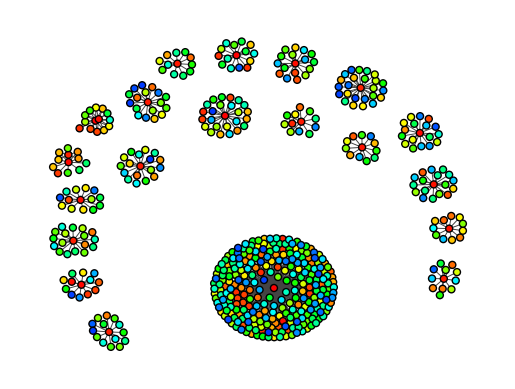

In [ ]:
import matplotlib.pyplot as plt
import random

# Just grab the top 100 most connected nodes and their neighbors
# Get component sizes and sort by number of nodes
comp_sizes = [(i, len(comp)) for i, comp in enumerate(comps)]
top_comp_indices = [i for i, _ in sorted(comp_sizes, key=lambda x: x[1], reverse=True)[:20]]

# Get all nodes from these top components
top_nodes = set()
for comp_idx in top_comp_indices:
    comp_nodes = comps[comp_idx]
    top_nodes.update(comp_nodes)

# Create subgraph from these nodes
subgraph = g.subgraph(list(top_nodes))

# Plotting the top 20 most connected components
fig, ax = plt.subplots()
ig.plot(
    subgraph,
    target=ax,
    palette=ig.RainbowPalette(),
    vertex_color=list(map(int, ig.rescale(comps.membership, (0, 250)))),
    vertex_size=7,
    edge_width=0.7
)
plt.show()

Validating our Results against iGraph

In [90]:
ours_grouped = (
    assignments
    .groupby("rep")
    .agg(col("u").agg_list().alias("members"))
    .collect()
)
pdf = ours_grouped.to_pandas()
ours_comps = {frozenset(m) for m in pdf["members"]}
ig_comps = {frozenset(node_ids[i] for i in comp) for comp in comps}
if ours_comps == ig_comps:
    print(f"[VALIDATION] PASSED: components match igraph (n={len(ours_comps)})")
else:
    only_ours = ours_comps - ig_comps
    only_ig = ig_comps - ours_comps
    def _preview(sets, k=3):
        out = []
        for comp in list(sets)[:k]:
            out.append(sorted(list(int(c) for c in comp))[:10])
        return out
    print(f"[VALIDATION] MISMATCH: ours={len(ours_comps)} vs igraph={len(ig_comps)}")
    print(f"  examples only in ours: {_preview(only_ours)}")
    print(f"  examples only in igraph: {_preview(only_ig)}")

/Users/everett-founder/git/ugh/daft-minhash-dedupe/.venv/lib/python3.11/site-packages/daft/dashboard/__init__.py:91: UserWarning: Failed to broadcast metrics over http://127.0.0.1:3238/api/queries: HTTP Error 400: Bad Request
  warnings.warn(f"Failed to broadcast metrics over {url}: {e}")


🗡️ 🐟 InMemorySource: 00:00 

🗡️ 🐟 GroupedAggregate: 00:00 

[VALIDATION] MISMATCH: ours=807 vs igraph=804
  examples only in ours: [[3434], [2205], [3599]]
  examples only in igraph: [[3582, 3599, 3651, 3652, 3736], [2149, 2205, 2206, 2213], [3416, 3434, 3487, 3488, 3579]]


### Getting our results to match: Global minimum label propagation
Why this is needed:
- After alternating Large-/Small-Star and applying path compression, components can still
    stabilize with multiple local minima (distinct labels) within the same true component.
- This deterministic min-label diffusion ensures every node in a connected component adopts
    the single global minimum node-id as its representative, restoring exact parity to igraph.

**Algorithm:**
1) Symmetrize edges to build an undirected adjacency (both directions present).
2) Initialize labels(u) from assignments.rep.
3) Iterate up to lp_max_iters times:
    a) For each node, compute nbr_min(u) = min(label(v)) over neighbors v of u.
    b) Update label(u) = min(label(u), nbr_min(u)) with null-safe handling.
    c) Deduplicate and compare to prior labels; stop when the (u, label) pair set stabilizes.
4) Return labels as assignments with schema ["u", "rep"].

In [101]:
# Build an undirected view of the graph so labels can flow in both directions
E = symmetrize(b_final)

# Initialize labels from current assignments: rep becomes the working label per node
labels = assignments.select(col("u"), col("rep").alias("label")).collect()

lp_iters = 0
lp_max_iters = 100
while lp_iters < lp_max_iters:
    lp_iters += 1

    # For each node u, compute the minimum label among its neighbors
    nbr_min = (
        E
        .join(labels, left_on="v", right_on="u", how="left")
        .select(col("u").alias("node"), col("label"))
        .groupby("node")
        .agg(col("label").min().alias("nbr_min"))
        .collect()
    )

    # Lower each node's label to min(current_label, neighbor_min_label)
    labels_next = (
        labels
        .join(nbr_min, left_on="u", right_on="node", how="left")
        .with_column(
            "label",
            col("nbr_min").is_null().if_else(
                col("label"),
                (col("label") <= col("nbr_min")).if_else(col("label"), col("nbr_min")),
            ),
        )
        .select(col("u"), col("label"))
        .distinct()
        .collect()
    )

    # Convergence: compare pair sets after casting back to (u, rep)
    a = assignments.select(col("u"), col("rep").alias("label")).select(col("u"), col("label").alias("rep"))
    b = labels_next.select(col("u"), col("label").alias("rep"))
    if pairs_equal(a, b):
        break

    # Continue iterating with updated assignments/labels
    assignments = labels_next.select(col("u"), col("label").alias("rep")).collect()
    labels = labels_next

assignments_globally_reduced = assignments
clear_output()



Checking one more time

In [102]:
ours_grouped = (
    assignments_globally_reduced
    .groupby("rep")
    .agg(col("u").agg_list().alias("members"))
    .collect()
)
pdf = ours_grouped.to_pandas()
ours_comps = {frozenset(m) for m in pdf["members"]}
ig_comps = {frozenset(node_ids[i] for i in comp) for comp in comps}
if ours_comps == ig_comps:
    print(f"[VALIDATION] PASSED: components match igraph (n={len(ours_comps)})")
else:
    only_ours = ours_comps - ig_comps
    only_ig = ig_comps - ours_comps
    def _preview(sets, k=3):
        out = []
        for comp in list(sets)[:k]:
            out.append(sorted(list(int(c) for c in comp))[:10])
        return out
    print(f"[VALIDATION] MISMATCH: ours={len(ours_comps)} vs igraph={len(ig_comps)}")
    print(f"  examples only in ours: {_preview(only_ours)}")
    print(f"  examples only in igraph: {_preview(only_ig)}")

🗡️ 🐟 InMemorySource: 00:00 

🗡️ 🐟 GroupedAggregate: 00:00 

[VALIDATION] PASSED: components match igraph (n=804)


## Merge Results


In [103]:
# First, create a mapping from node IDs to their string representations
assignments_unique = (
    assignments_globally_reduced
    .groupby("u")
    .agg(col("rep").min())
)

In [104]:
# Join the assignments with the ID mapping to get string representations
a1 = assignments_unique.join(id_map.with_column_renamed(index_col, "__u_str"), left_on="u", right_on="node_id")
a2 = a1.join(id_map.with_column_renamed(index_col, "__rep_str"), left_on="rep", right_on="node_id")
assignments_unique_str = a2.select(
    col("__u_str").alias(index_col),
    col("__rep_str").alias("component")
)

In [105]:
# Join back to original df and filter to keep only rows where the row is its own representative or isolated
df_joined = df_text.join(assignments_unique_str, on=index_col, how="left")

In [107]:
# Return the deduplicated dataset with only unique representatives
deduplicated_df = (
    df_joined
    .filter(
        col("component").is_null() | 
        (col("component") == col(index_col))
    )
    .exclude("component")
).collect()
clear_output()

In [108]:
deduplicated_df.show()

block_idUtf8,WARC-Record-IDUtf8,blockUtf8
33fb1024-47b8-4fc0-814c-565052602683-0,33fb1024-47b8-4fc0-814c-565052602683,Jahreshauptversammlung des 1. JJJC Lünen | 1. JJJC Lünen e.V.
33fb1024-47b8-4fc0-814c-565052602683-1,33fb1024-47b8-4fc0-814c-565052602683,"Jahreshauptversammlung des 1. JJJC Lünen Veröffentlicht am 6. April 2018 von admin Mit immerhin 20 stimmberechtigten Mitgliedern war die diesjährige Jahreshauptversammlung des 1. JJJC Lünen trotz des Beginns der Osterferien ganz ordentlich besucht. Neben den Berichten der Vorsitzenden, des Kassierers, der Kassenprüfer und der Jugendvertreter stand auch die Nachwahl eines Sportwartes incl. Vertreters an. Hier erklärten sich Meike Euler und Chantal Jakscht bereit, diese Aufgabe zu übernehmen. Außerdem wurden, wie in jedem Jahr, langjährige Vereinsmitglieder mit einem kleinen Präsent geehrt. In diesem Jahr feiern Sven Kotissek 15-jährige Mitgliedschaft sowie Anja Meister und ihr Sohn Jan Meister 10-jährige Mitgliedschaft im 1. JJJC Lünen. Schließlich wurden an die Trainer als kleines Dankeschön für ihr Engagement noch neue Hoodies verteilt. Das Bild zeigt den geschäftsführenden Vorstand des 1. JJJC Lünen mit den geehrten Jubilaren (v. l.): Heike Tatsch (1. Vorsitzende), Kathryn Köthe-Kosmowski (2. Geschäftsführerin), Martin Köthe (2. Kassierer), Sven Kotissek (15 Jahre), Anja Meister (10 Jahre), Wolfgang Hübenthal (1. Kassierer), Jan Meister (10 Jahre) und Martin Tatsch (2. Vorsitzender) Dieser Eintrag wurde veröffentlicht in Allgemein von admin . Permanenter Link des Eintrags ."
33fb1024-47b8-4fc0-814c-565052602683-2,33fb1024-47b8-4fc0-814c-565052602683,"Mit immerhin 20 stimmberechtigten Mitgliedern war die diesjährige Jahreshauptversammlung des 1. JJJC Lünen trotz des Beginns der Osterferien ganz ordentlich besucht. Neben den Berichten der Vorsitzenden, des Kassierers, der Kassenprüfer und der Jugendvertreter stand auch die Nachwahl eines Sportwartes incl. Vertreters an. Hier erklärten sich Meike Euler und Chantal Jakscht bereit, diese Aufgabe zu übernehmen. Außerdem wurden, wie in jedem Jahr, langjährige Vereinsmitglieder mit einem kleinen Präsent geehrt. In diesem Jahr feiern Sven Kotissek 15-jährige Mitgliedschaft sowie Anja Meister und ihr Sohn Jan Meister 10-jährige Mitgliedschaft im 1. JJJC Lünen. Schließlich wurden an die Trainer als kleines Dankeschön für ihr Engagement noch neue Hoodies verteilt."
33fb1024-47b8-4fc0-814c-565052602683-3,33fb1024-47b8-4fc0-814c-565052602683,"Das Bild zeigt den geschäftsführenden Vorstand des 1. JJJC Lünen mit den geehrten Jubilaren (v. l.): Heike Tatsch (1. Vorsitzende), Kathryn Köthe-Kosmowski (2. Geschäftsführerin), Martin Köthe (2. Kassierer), Sven Kotissek (15 Jahre), Anja Meister (10 Jahre), Wolfgang Hübenthal (1. Kassierer), Jan Meister (10 Jahre) und Martin Tatsch (2. Vorsitzender)"
33fb1024-47b8-4fc0-814c-565052602683-4,33fb1024-47b8-4fc0-814c-565052602683,1. JJJC Lünen e.V.
33fb1024-47b8-4fc0-814c-565052602683-5,33fb1024-47b8-4fc0-814c-565052602683,Jahreshauptversammlung des 1. JJJC Lünen
33fb1024-47b8-4fc0-814c-565052602683-6,33fb1024-47b8-4fc0-814c-565052602683,Judo und Ninjitsu
33fb1024-47b8-4fc0-814c-565052602683-7,33fb1024-47b8-4fc0-814c-565052602683,Hauptmenü


## Conclusion